In [87]:
import numpy as np
import pandas as pd
import json
import pandasql as psql
import eng_to_ipa as ipa
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Datasets

In [135]:
movies_df = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t',names=['Wikipedia_ID','Freebase_ID','Name','Release_date','Box_office_revenues','Runtime','Languages','Country','Genres'])
#movies_df.head()

In [136]:
character_df = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t', names=['Wikipedia_ID','Freebase_ID','Release_date','Character_name','Actor_DOB',
                                                                                    'Sex','Height','Ethnicity','Actor_name','Actor_age','Freebase_character_map'
                                                                                    ,'?','??'])##

In [137]:
# Cleaning Languages, Country and Genres Columns

def str_dict_to_values(dict_in_str: str)->list[str]:
    
    if dict_in_str is None:  
        return []
    dict_ = json.loads(dict_in_str)
    values = list(dict_.values())
    return values

movies_df['Languages'] = movies_df['Languages'].apply(str_dict_to_values)
movies_df['Country'] =movies_df['Country'].apply(str_dict_to_values)
movies_df['Genres'] =movies_df['Genres'].apply(str_dict_to_values)



In [138]:
# Merging the 2 datasets and keeping only interesting features

phonetic_df = pd.merge(movies_df,character_df, on="Wikipedia_ID",how="inner")[['Wikipedia_ID','Name','Languages','Country','Genres','Character_name']]

phonetic_df.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Desolation Williams
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Sgt Jericho Butler
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira Kincaid


## Handling NaN values

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_62339/390455297.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_62339/390455297.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(missing_values_character.index, rotation=90)


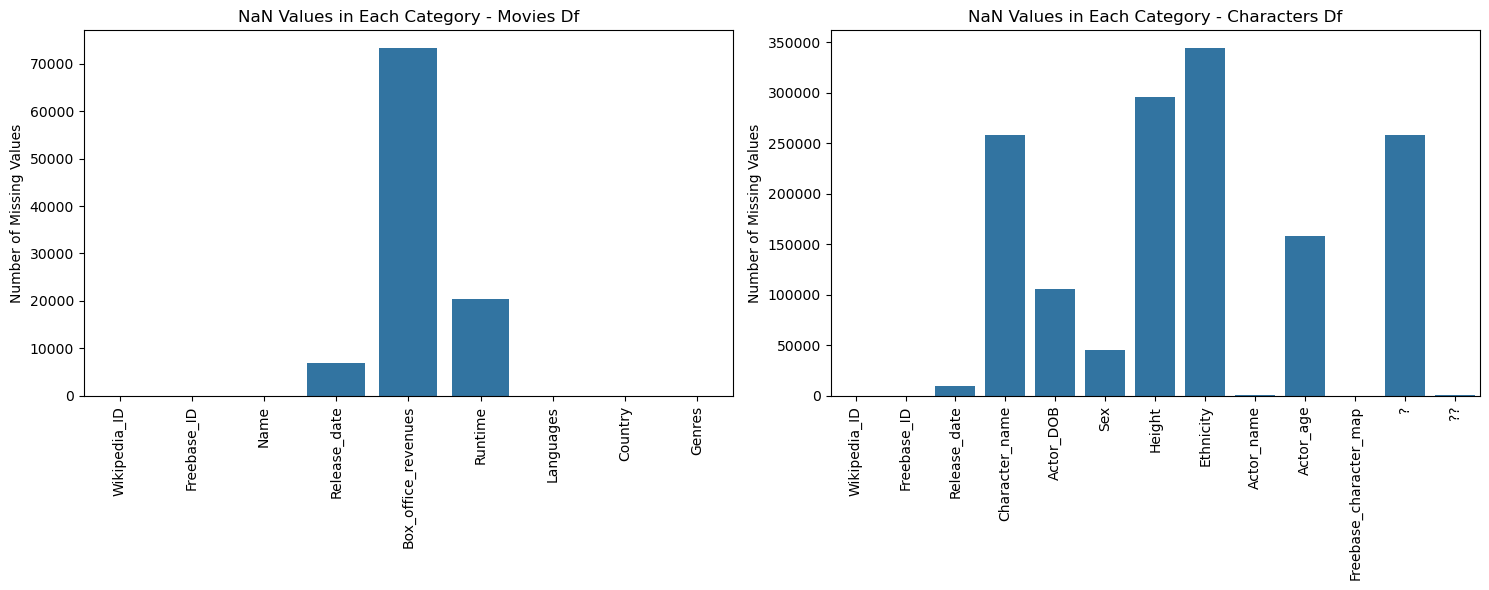

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

missing_values_movies = movies_df.isnull().sum()
missing_values_character = character_df.isnull().sum()

sns.barplot(x=missing_values_movies.index, y=missing_values_movies.values, ax=axs[0])
axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Missing Values')
axs[0].set_title('NaN Values in Each Category - Movies Df')

# Second subplot (could be modified if you want to show different data or style)
sns.barplot(x=missing_values_character.index, y=missing_values_character.values, ax=axs[1])
axs[1].set_xticklabels(missing_values_character.index, rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of Missing Values')
axs[1].set_title('NaN Values in Each Category - Characters Df')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Removing Nan Values from Character's names

In [140]:
def remove_nan_rows(df:pd.DataFrame,column:str)->pd.DataFrame:
    no_nan_df = df.dropna(subset=[column])
    return no_nan_df

character_df = remove_nan_rows(character_df,'Character_name')

phonetic_df = remove_nan_rows(phonetic_df,'Character_name')

## Common names cleaning

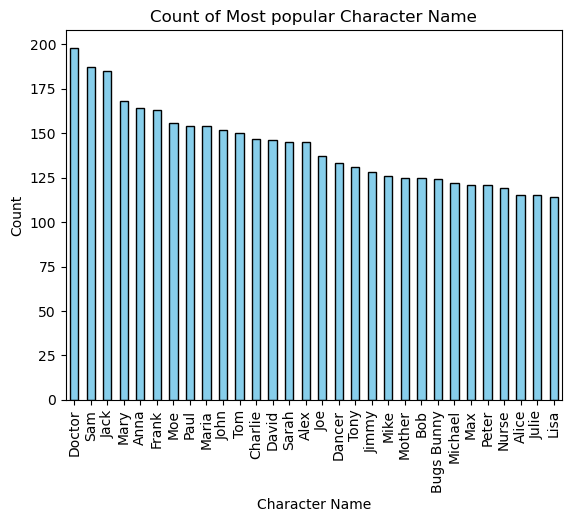

In [141]:
name_counts = character_df['Character_name'].value_counts()

top_names_bar = name_counts.head(30)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

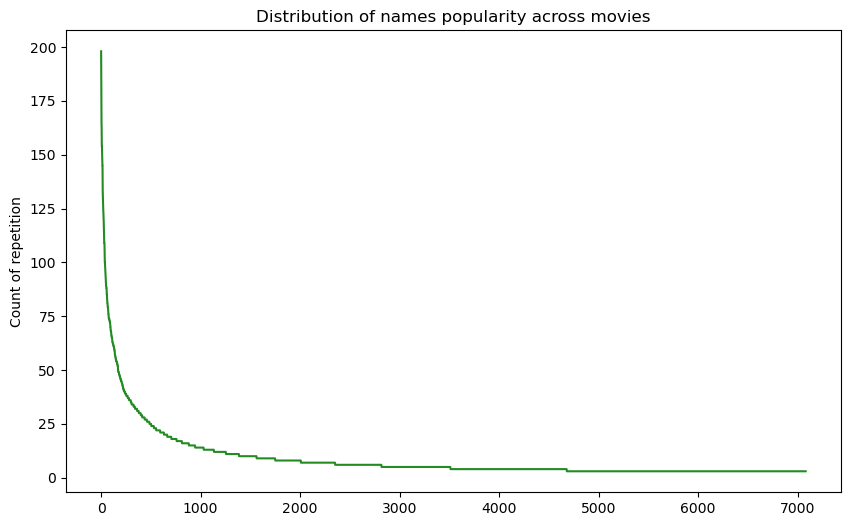

In [142]:
repeated_names = name_counts[name_counts>=3]
plt.figure(figsize=(10, 6))
plt.plot(repeated_names.values, color='forestgreen', linestyle='-', markersize=5)
plt.ylabel("Count of repetition")
plt.title("Distribution of names popularity across movies")
plt.show()

In [143]:
import nltk
nltk.download('words')
from nltk.corpus import words

english_words = set(words.words())                                                        # Liste de 235892 mots anglais   
invalid_chars = ['-', '/', '.', ',',"'", '"', '#',"(",')','0','1','2','3','4','5','6','7','8','9']
def filter_non_english_names(name):
    words_in_name = name.split()                                                             # Sépare le nom en mots individuels
    filtered_words = [word for word in words_in_name if word.lower() not in english_words and all(char not in word for char in invalid_chars)]   # Filtre les mots qui ne sont pas dans la liste des mots anglais et ceux qui contiennent '-' ou '/'
    return ' '.join(filtered_words)    


[nltk_data] Downloading package words to /Users/luca/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [144]:

print(character_df['Character_name'].shape)

character_df['Character_name']=character_df['Character_name'].apply(filter_non_english_names)

print(character_df['Character_name'].shape)

(192794,)
(192794,)


In [145]:
# Deleting Empty names

values_filtered = character_df['Character_name'].value_counts()
deleted_names = character_df[character_df['Character_name']==values_filtered.index[0]]
values_filtered.head()

Character_name
          52867
John        520
Tom         304
George      278
Paul        269
Name: count, dtype: int64

In [146]:
kept_names = character_df[character_df['Character_name']!=values_filtered.index[0]]
kept_names.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [123]:
def keep_first_name(name:str)->str:
    return name.split()[0] if name else ""

kept_names['Character_name'] = character_df['Character_name'].apply(keep_first_name)
kept_names.head()

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_62339/3669916037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['Character_name'] = character_df['Character_name'].apply(keep_first_name)


,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


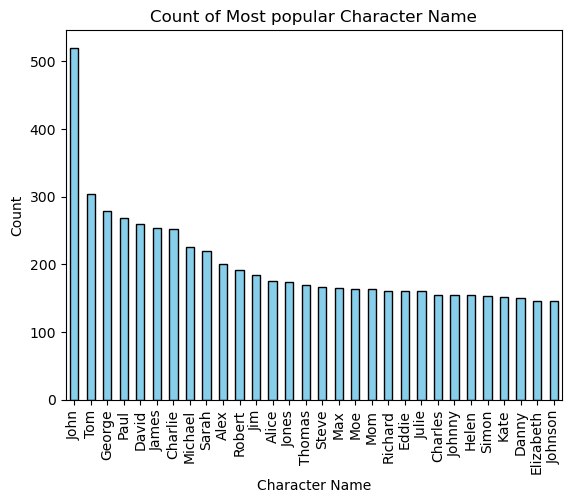

In [147]:
name_counts = kept_names['Character_name'].value_counts()

top_names_bar = name_counts.head(30)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

In [85]:
#Converting character's names to their phonetic equivalent

unique_strings = phonetic_df['Character_name'].unique()

# We map every unique string to their phonetic equivalent
phonetic_map = {word: ipa.convert(word) for word in unique_strings}


phonetic_df['Phonetic'] = phonetic_df['Character_name'].map(phonetic_map)


KeyboardInterrupt: 